# Objective
The problem is to build and test a model that will predict the tone (neutral or negative) of the text message. The model has to predict the class (neutral or negative) and test results reported on test data that was not used to train the model. An ideal model should not miss predicting a negative tone in the message text.

So here, we have to improve prediction of Negative sentiment. We want our model to not ignore negative comments. We want to reduce False Positives i.e. Original sentiment is negative but we are predicting positive.

SP (specificity) – reflects the classifier’s ability to detect members of the negative class

SP = TN / (TN + FP)

## Importing Libraries

In [57]:
# 4.1. Import library: 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


from wordcloud import WordCloud
import nltk
import re
import string
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


stop_words = stopwords.words()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
# 4.2. Import the data:
df=pd.read_csv('data.csv')
df.head()

,textID,text,sentiment
0,2a0463352b,that`s enough! I`ll do nothing for 2 hours.,neutral
1,f358968122,I have to go clothes shopping tomorrow I hate...,negative
2,449e7733f1,i am bored. :| any idea`s of a nice site?,neutral
3,6099baf6e8,I don`t think will want to come back (guys r...,negative
4,f946da7a04,_thomas if only the drinking game was tonight....,neutral


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18899 entries, 0 to 18898
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     18899 non-null  object
 1   text       18898 non-null  object
 2   sentiment  18899 non-null  object
dtypes: object(3)
memory usage: 443.1+ KB


In [60]:
df.describe().T

,count,unique,top,freq
textID,18899,18899,2a0463352b,1
text,18898,18888,I see,2
sentiment,18899,2,neutral,11118


### Removing null values

In [61]:
df.dropna(inplace=True)
df.shape

(18898, 3)

In [62]:
df.pop('textID')
df.head()

,text,sentiment
0,that`s enough! I`ll do nothing for 2 hours.,neutral
1,I have to go clothes shopping tomorrow I hate...,negative
2,i am bored. :| any idea`s of a nice site?,neutral
3,I don`t think will want to come back (guys r...,negative
4,_thomas if only the drinking game was tonight....,neutral


## EDA:

In [63]:
#sentiment count: 
df['sentiment'].value_counts()

neutral     11117
negative     7781
Name: sentiment, dtype: int64

Here we have more neutral text than negative text.

Next, We’ll take a look at the number of characters present in each sentence. This can give us a rough idea about the movie's review.

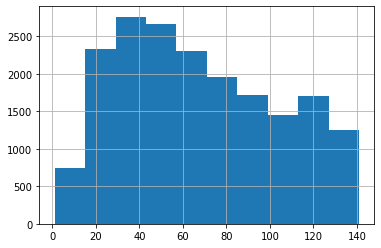

In [64]:
df['text'].str.len().hist()


The histogram shows that reviews range upto 140 characters.

Now, we will move on the histogram for neutral text and negative text respectively. Let's plot!

Text(0.5, 1.0, 'Negative Text')

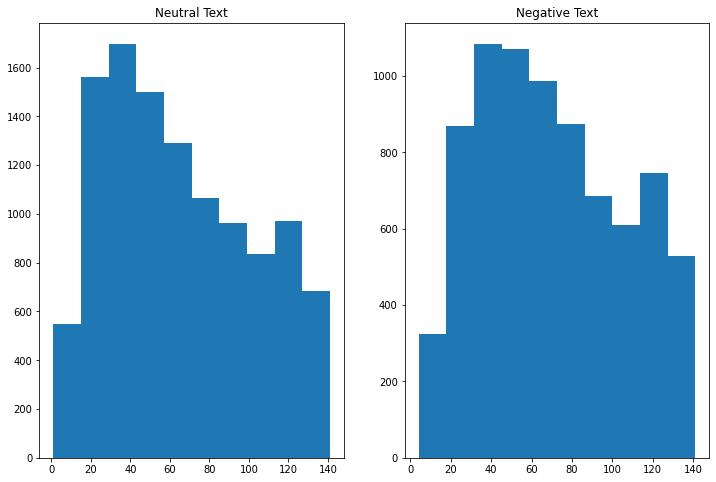

In [65]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
ax1.hist(df[df['sentiment']=='neutral']['text'].str.len())
ax1.set_title( 'Neutral Text')
ax2.hist(df[df['sentiment']=='negative']['text'].str.len())
ax2.set_title( 'Negative Text')

we can observe some insights from the graph above: 
- Most people are  commenting less words
- In general, people comment less word in the neutral review to compare with negative review


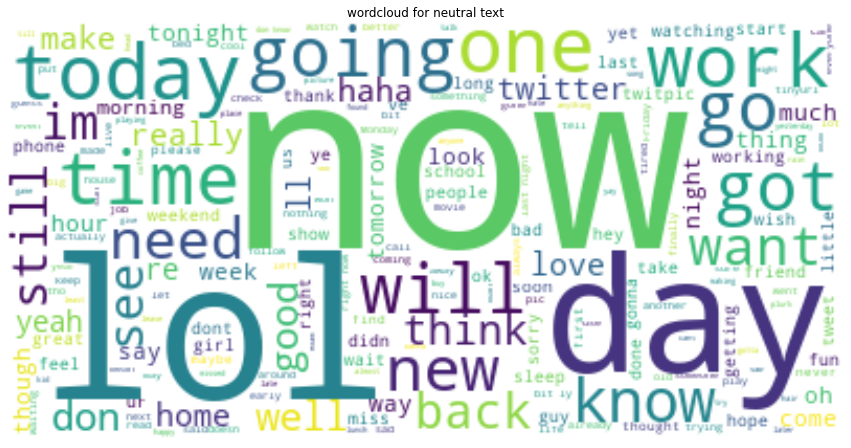

In [66]:
text = " ".join(i for i in df[df['sentiment']=='neutral']['text'])
wordcloud = WordCloud( background_color="white").generate(text)

plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud for neutral text')
plt.show()

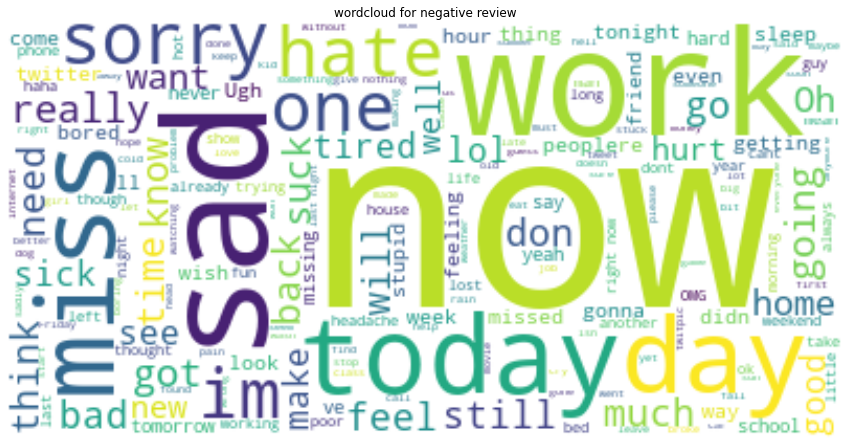

In [67]:
text = " ".join(i for i in df[df['sentiment']=='negative']['text'])
#stopwords = set(STOPWORDS)
wordcloud = WordCloud( background_color="white").generate(text)
#wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud for negative review')
plt.show()

The wordcloud graphs in both negative and postitive comments don't show meaningful result. 

That's is the reason why text preprosessing is needed. 

Let's start the preproceesing process. 

## PREPROCESSING:

In [68]:
def cleaning(text):        
    # converting to lowercase, removing URL links, special characters, punctuations...
    text = text.lower() # converting to lowercase
    text = re.sub('https?://\S+|www\.\S+', '', text) # removing URL links
    text = re.sub('[^a-z]',' ',text) # anything not in a-z is being removed
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
    
dt = df['text'].apply(cleaning)

In [69]:
# df['sentiment']

In [70]:
dt = pd.DataFrame(dt)  
dt['sentiment']=df['sentiment']
dt.head()

,text,sentiment
0,that s enough i ll do nothing for hours,neutral
1,i have to go clothes shopping tomorrow i hate...,negative
2,i am bored any idea s of a nice site,neutral
3,i don t think will want to come back guys r...,negative
4,thomas if only the drinking game was tonight ...,neutral


In [71]:
# remove stop word: 
dt['no_sw'] = dt['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [72]:
dt.head(3)

,text,sentiment,no_sw
0,that s enough i ll do nothing for hours,neutral,enough nothing hours
1,i have to go clothes shopping tomorrow i hate...,negative,go clothes shopping tomorrow hate serious clot...
2,i am bored any idea s of a nice site,neutral,bored idea nice site


In [73]:
#Working with the most Frequent Words: 
from collections import Counter
cnt = Counter()
for text in dt['no_sw'].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(10)
temp = pd.DataFrame(cnt.most_common(10))
temp.columns=['word', 'count']
temp

,word,count
0,get,1065
1,go,986
2,like,935
3,work,895
4,day,887
5,going,817
6,today,788
7,got,779
8,know,686
9,lol,668


In [74]:
#Working with the most Frequent Words: 
from collections import Counter
cnt = Counter()
for text in dt[dt["sentiment"]=='negative']['no_sw'].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(10)
neg_temp = pd.DataFrame(cnt.most_common(10))
neg_temp.columns=['word', 'count']
neg_temp

,word,count
0,like,478
1,get,436
2,miss,426
3,go,403
4,work,403
5,sad,397
6,sorry,352
7,really,344
8,day,343
9,today,340


In [75]:
px.bar(neg_temp, x="count", y="word", title='Commmon Words in Negative Text', orientation='h', 
             width=700, height=700)


We can see most common negative sentiment words has like, get, go, really, day, today which are not helping much in identification of negative sentiment

To improve our model we can try to remove common words which occur in both Negative text and overall text

## Wordcloud after cleaning and removing stopwords

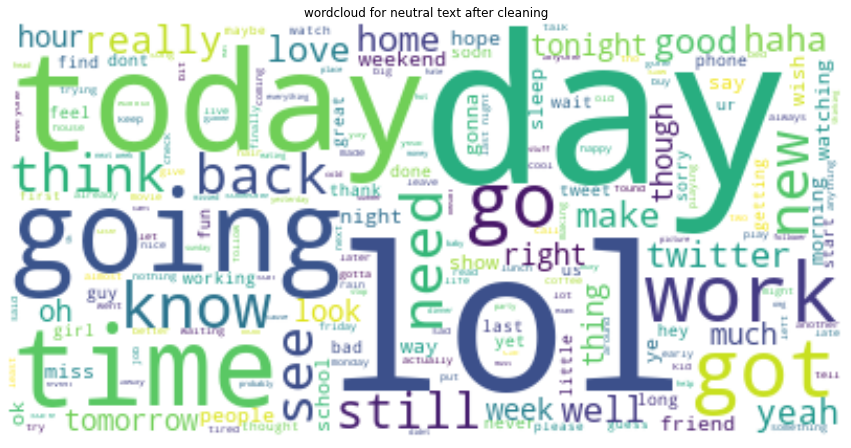

In [76]:
text = " ".join(i for i in dt[dt['sentiment']=='neutral']['no_sw'])
wordcloud = WordCloud( background_color="white").generate(text)

plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud for neutral text after cleaning')
plt.show()

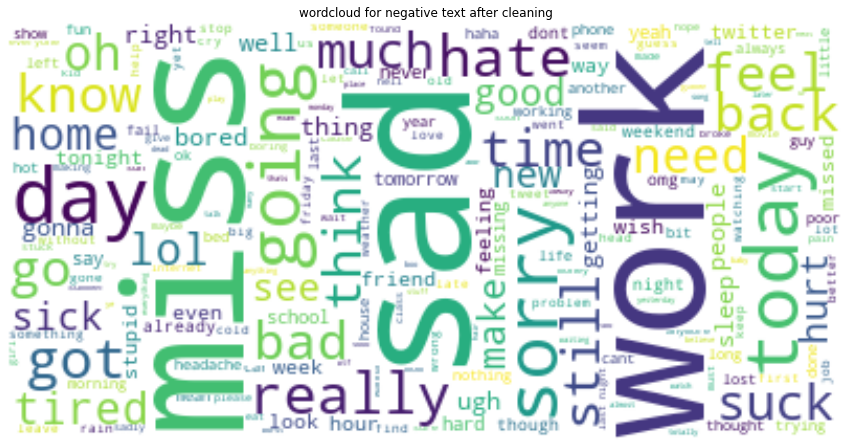

In [77]:
text = " ".join(i for i in dt[dt['sentiment']=='negative']['no_sw'])
wordcloud = WordCloud( background_color="white").generate(text)

plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud for negative text after cleaning')
plt.show()

# Further cleaning for negative text

In [78]:
common_neg_words = set(temp['word']).intersection( set(neg_temp['word']) )
common_neg_words

{'day', 'get', 'go', 'like', 'today', 'work'}

In [79]:
# remove stop word: 
dt['no_sw_neg'] = dt[dt['sentiment']=='negative']['no_sw'].apply(lambda x: ' '.join([word for word in x.split() if word not in (common_neg_words)]))
dt.head()

,text,sentiment,no_sw,no_sw_neg
0,that s enough i ll do nothing for hours,neutral,enough nothing hours,NaN
1,i have to go clothes shopping tomorrow i hate...,negative,go clothes shopping tomorrow hate serious clot...,clothes shopping tomorrow hate serious clothes...
2,i am bored any idea s of a nice site,neutral,bored idea nice site,NaN
3,i don t think will want to come back guys r...,negative,think back guys read dms,think back guys read dms
4,thomas if only the drinking game was tonight ...,neutral,thomas drinking game tonight work tomorrow,NaN


In [80]:
dt['no_sw_neg2'] = dt['no_sw']

In [81]:
# remove stop word: 
dt['no_sw_neg2'] = dt[dt['sentiment']=='neutral']['no_sw']
dt.head()

,text,sentiment,no_sw,no_sw_neg,no_sw_neg2
0,that s enough i ll do nothing for hours,neutral,enough nothing hours,NaN,enough nothing hours
1,i have to go clothes shopping tomorrow i hate...,negative,go clothes shopping tomorrow hate serious clot...,clothes shopping tomorrow hate serious clothes...,NaN
2,i am bored any idea s of a nice site,neutral,bored idea nice site,NaN,bored idea nice site
3,i don t think will want to come back guys r...,negative,think back guys read dms,think back guys read dms,NaN
4,thomas if only the drinking game was tonight ...,neutral,thomas drinking game tonight work tomorrow,NaN,thomas drinking game tonight work tomorrow


In [82]:
dt['no_sw_neg_f'] = dt["no_sw_neg"].fillna('')+dt['no_sw_neg2'].fillna('')
dt.head()

,text,sentiment,no_sw,no_sw_neg,no_sw_neg2,no_sw_neg_f
0,that s enough i ll do nothing for hours,neutral,enough nothing hours,NaN,enough nothing hours,enough nothing hours
1,i have to go clothes shopping tomorrow i hate...,negative,go clothes shopping tomorrow hate serious clot...,clothes shopping tomorrow hate serious clothes...,NaN,clothes shopping tomorrow hate serious clothes...
2,i am bored any idea s of a nice site,neutral,bored idea nice site,NaN,bored idea nice site,bored idea nice site
3,i don t think will want to come back guys r...,negative,think back guys read dms,think back guys read dms,NaN,think back guys read dms
4,thomas if only the drinking game was tonight ...,neutral,thomas drinking game tonight work tomorrow,NaN,thomas drinking game tonight work tomorrow,thomas drinking game tonight work tomorrow


In [83]:
dt.drop(['no_sw_neg','no_sw_neg2'], inplace=True, axis=1)

In [84]:
dt[dt['sentiment']=='negative']

,text,sentiment,no_sw,no_sw_neg_f
1,i have to go clothes shopping tomorrow i hate...,negative,go clothes shopping tomorrow hate serious clot...,clothes shopping tomorrow hate serious clothes...
3,i don t think will want to come back guys r...,negative,think back guys read dms,think back guys read dms
6,i wish the sun would come out i guess it doe...,negative,wish sun would guess matter since work enjoy a...,wish sun would guess matter since enjoy anyways
7,i am very sad because i have gone on the show ...,negative,sad gone show mcfly fan,sad gone show mcfly fan
8,no one ever gave me the info i m sad,negative,ever gave info sad,ever gave info sad
...,...,...,...,...
18891,i miss nicc today,negative,miss nicc today,miss nicc
18892,my entire body hurts shower hot tea and tv ...,negative,entire body hurts shower hot tea tv please,entire body hurts shower hot tea tv please
18893,youtube s tubes appear to be clogging up somew...,negative,youtube tubes appear clogging somewhat today c...,youtube tubes appear clogging somewhat connect...
18895,bit devastated that i lost my entire documents...,negative,bit devastated lost entire documents folder ho...,bit devastated lost entire documents folder ho...


In [85]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [86]:
dt['stemmed'] = dt['no_sw']
from nltk.stem.porter import PorterStemmer 
porter = PorterStemmer()
from nltk.tokenize import sent_tokenize, word_tokenize
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

for i in range(0,18898):
  dt.iloc[i,4] = stemSentence(dt.iloc[i,4])

dt.head()

,text,sentiment,no_sw,no_sw_neg_f,stemmed
0,that s enough i ll do nothing for hours,neutral,enough nothing hours,enough nothing hours,enough noth hour
1,i have to go clothes shopping tomorrow i hate...,negative,go clothes shopping tomorrow hate serious clot...,clothes shopping tomorrow hate serious clothes...,go cloth shop tomorrow hate seriou cloth fall ...
2,i am bored any idea s of a nice site,neutral,bored idea nice site,bored idea nice site,bore idea nice site
3,i don t think will want to come back guys r...,negative,think back guys read dms,think back guys read dms,think back guy read dm
4,thomas if only the drinking game was tonight ...,neutral,thomas drinking game tonight work tomorrow,thomas drinking game tonight work tomorrow,thoma drink game tonight work tomorrow


In [87]:
dt['stemmed_2'] = dt['no_sw_neg_f']
from nltk.stem.porter import PorterStemmer 
porter = PorterStemmer()
from nltk.tokenize import sent_tokenize, word_tokenize
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

for i in range(0,18898):
  dt.iloc[i,5] = stemSentence(dt.iloc[i,5])

dt.head()

,text,sentiment,no_sw,no_sw_neg_f,stemmed,stemmed_2
0,that s enough i ll do nothing for hours,neutral,enough nothing hours,enough nothing hours,enough noth hour,enough noth hour
1,i have to go clothes shopping tomorrow i hate...,negative,go clothes shopping tomorrow hate serious clot...,clothes shopping tomorrow hate serious clothes...,go cloth shop tomorrow hate seriou cloth fall ...,cloth shop tomorrow hate seriou cloth fall apa...
2,i am bored any idea s of a nice site,neutral,bored idea nice site,bored idea nice site,bore idea nice site,bore idea nice site
3,i don t think will want to come back guys r...,negative,think back guys read dms,think back guys read dms,think back guy read dm,think back guy read dm
4,thomas if only the drinking game was tonight ...,neutral,thomas drinking game tonight work tomorrow,thomas drinking game tonight work tomorrow,thoma drink game tonight work tomorrow,thoma drink game tonight work tomorrow


### Now, the data is clean! we can move to the next step: Navie_Bayes Modelling!

# 4.3. Tokenization

In [88]:
# create the cleaned data for the train-test split:
nb=dt.drop(columns=['text','no_sw','no_sw_neg_f','stemmed_2'])
nb.columns=['sentiment','mod_text']
nb.sentiment = [0 if each == "negative" else 1 for each in nb.sentiment]
nb.head()

,sentiment,mod_text
0,1,enough noth hour
1,0,go cloth shop tomorrow hate seriou cloth fall ...
2,1,bore idea nice site
3,0,think back guy read dm
4,1,thoma drink game tonight work tomorrow


In [89]:
tokenized_review=nb['mod_text'].apply(lambda x: x.split())
tokenized_review.head(5)

0                                 [enough, noth, hour]
1    [go, cloth, shop, tomorrow, hate, seriou, clot...
2                             [bore, idea, nice, site]
3                         [think, back, guy, read, dm]
4        [thoma, drink, game, tonight, work, tomorrow]
Name: mod_text, dtype: object

In [90]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(nb['mod_text'])

In [91]:
# create the 2nd cleaned data for the train-test split:
nb2=dt.drop(columns=['text','no_sw','no_sw_neg_f','stemmed'])
nb2.columns=['sentiment','mod_text']
nb2.sentiment = [0 if each == "negative" else 1 for each in nb2.sentiment]
nb2.head()

,sentiment,mod_text
0,1,enough noth hour
1,0,cloth shop tomorrow hate seriou cloth fall apa...
2,1,bore idea nice site
3,0,think back guy read dm
4,1,thoma drink game tonight work tomorrow


In [92]:
tokenized_review2=nb2['mod_text'].apply(lambda x: x.split())
tokenized_review2.head(5)

0                                 [enough, noth, hour]
1    [cloth, shop, tomorrow, hate, seriou, cloth, f...
2                             [bore, idea, nice, site]
3                         [think, back, guy, read, dm]
4        [thoma, drink, game, tonight, work, tomorrow]
Name: mod_text, dtype: object

In [93]:
text_counts2 = cv.fit_transform(nb2['mod_text'])

# 4.4. Train-test Split: 

In [94]:
from sklearn.model_selection import train_test_split
X=text_counts
y=nb['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=30)

In [95]:
X2=text_counts2
y2=nb2['sentiment']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20,random_state=30)

We will now split the data for training and testing to check how well our model has performed. 

Also we will randomize the data in case our data includes all positive first and then all negative or some other kind of bias. 

We will use: scikit_learn's train_test_split() for splitting the text_count (which contains our X) and dataset['Sentiment'] (this contains Y).

## Specificity

In [96]:
def cal_specif(cm):
  spec = cm[0,0]/(cm[0,0]+cm[0,1])
  return spec

# Navies Bayes Modelling:


In this section, we will go through different Navies Bayes Model: ComplementNB, MultinatinominalNB, BernoulliNB and see how accuracy each model can be:

### a) Complement NB model:

In [97]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix
CNB = ComplementNB()
CNB.fit(X_train, y_train)

from sklearn import metrics
predicted = CNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('ComplementNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))

ComplementNB model accuracy is 69.42%
------------------------------------------------
Confusion Matrix:
      0     1
0  1101   486
1   670  1523
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.69      0.66      1587
           1       0.76      0.69      0.72      2193

    accuracy                           0.69      3780
   macro avg       0.69      0.69      0.69      3780
weighted avg       0.70      0.69      0.70      3780



*   Here this Complement NB model has correctly predicted 1101 out of 1587 negative reviews

In [98]:
print('Specificity of Complement NB:')
print(cal_specif(confusion_matrix(y_test, predicted)))

Specificity of Complement NB:
0.6937618147448015


In [99]:
# For updated model
CNB2 = ComplementNB()
CNB2.fit(X2_train, y2_train)

predicted2 = CNB2.predict(X2_test)
accuracy_score2 = metrics.accuracy_score(predicted2, y2_test)

print('ComplementNB2 model accuracy is',str('{:04.2f}'.format(accuracy_score2*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y2_test, predicted2)))
print('------------------------------------------------')

ComplementNB2 model accuracy is 70.93%
------------------------------------------------
Confusion Matrix:
      0     1
0  1119   468
1   631  1562
------------------------------------------------


Here we can clearly see that the recall has improved for the model where the most common words in negative text and whole dataset has been removed from negative text.

In [100]:
print('Specificity of Complement NB with updated negative data:')
print(cal_specif(confusion_matrix(y2_test, predicted2)))

Specificity of Complement NB with updated negative data:
0.7051039697542533


### b) Mutilnominal NB model:

In [101]:
from sklearn.naive_bayes import MultinomialNB

MNB = MultinomialNB()
MNB.fit(X_train, y_train)

predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('MultinominalNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')

MultinominalNB model accuracy is 72.12%
------------------------------------------------
Confusion Matrix:
     0     1
0  955   632
1  422  1771
------------------------------------------------


In [102]:
# For 2nd model
MNB2 = MultinomialNB()
MNB2.fit(X2_train, y2_train)

predicted2 = MNB2.predict(X2_test)
accuracy_score2 = metrics.accuracy_score(predicted2, y2_test)

print('MultinominalNB2 model accuracy is',str('{:04.2f}'.format(accuracy_score2*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y2_test, predicted2)))
print('------------------------------------------------')

MultinominalNB2 model accuracy is 73.62%
------------------------------------------------
Confusion Matrix:
     0     1
0  993   594
1  403  1790
------------------------------------------------


In [103]:
print('Specificity of Multinomial NB with updated negative data:')
print(cal_specif(confusion_matrix(y2_test, predicted2)))

Specificity of Multinomial NB with updated negative data:
0.6257088846880907


*   Complement NB model correctly predicts 1101 (1119 for updated) out of 1587 negative text
*   Multinomial NB model correctly predicts 955 (993) out of 1587 negative text




# Trying different n-grams:


### a) Bigram: ngram_range = (2,2)

In [104]:

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv_twograms = CountVectorizer(stop_words='english',ngram_range = (2,2),tokenizer = token.tokenize)
text_counts_twograms = cv_twograms.fit_transform(nb['mod_text'])
text_counts_twograms2 = cv_twograms.fit_transform(nb2['mod_text'])
X_train, X_test, y_train, y_test = train_test_split(text_counts_twograms, nb['sentiment'], test_size=0.20,random_state=30)

X2_train, X2_test, y2_train, y2_test = train_test_split(text_counts_twograms2, nb2['sentiment'], test_size=0.20,random_state=30)

MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)
recall_score = metrics.recall_score(predicted, y_test)
print('Bigrams model recall is',str('{:04.2f}'.format(recall_score*100))+'%')

Bigrams model recall is 65.00%


In [105]:
MNB2 = MultinomialNB()
MNB2.fit(X2_train, y2_train)
predicted2 = MNB2.predict(X2_test)
recall_score2 = metrics.recall_score(predicted2, y2_test)
print('Bigrams model recall with updated dataset and multinomial NB is',str('{:04.2f}'.format(recall_score2*100))+'%')

Bigrams model recall with updated dataset and multinomial NB is 66.50%


### b) Trigram: ngram_range= (3,3)¶

In [106]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv_threegrams = CountVectorizer(stop_words='english',ngram_range = (3,3),tokenizer = token.tokenize)
text_counts_threegrams = cv_threegrams.fit_transform(nb['mod_text'])

X_train, X_test, y_train, y_test = train_test_split(text_counts_threegrams, nb['sentiment'], test_size=0.20,random_state=30)

MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)
accuracy_score = metrics.recall_score(predicted, y_test)
print('model recall is',str('{:04.2f}'.format(accuracy_score*100))+'%')


model recall is 59.85%


# TF-IDF: Term Frequency-Inverse Document Frequency

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
text_count_new = tfidf.fit_transform(nb['mod_text'])
text_count_new2 = tfidf.fit_transform(nb2['mod_text'])

In [108]:
#splitting the data in test and training
#from sklearn.model_selection() import train_test_split()
x_train, x_test, y_train, y_test = train_test_split(text_count_new, nb['sentiment'],test_size=0.20,random_state=30)
x2_train, x2_test, y2_train, y2_test = train_test_split(text_count_new2, nb2['sentiment'],test_size=0.20,random_state=30)

In [109]:
#fitting the model with MNB
MNB.fit(x_train, y_train)
predicted = MNB.predict(x_test)
accuracy_score_mnb = metrics.recall_score(MNB.predict(x_test), y_test)

print('recall_score_mnb = '+str('{:4.2f}'.format(accuracy_score_mnb*100))+'%')
print('specificity_mnb = '+str('{:4.2f}'.format(cal_specif(confusion_matrix(y_test, MNB.predict(x_test)))*100))+'%')
print(confusion_matrix(y_test, predicted))

recall_score_mnb = 68.68%
specificity_mnb = 42.22%
[[ 670  917]
 [ 182 2011]]


In [110]:
#fitting the model with MNB
MNB.fit(x2_train, y2_train)
predicted2 = MNB.predict(x2_test)
recall_score_mnb2 = metrics.recall_score(MNB.predict(x2_test), y2_test)

print('recall_score_mnb2 = '+str('{:4.2f}'.format(recall_score_mnb2*100))+'%')
print('specificity_mnb2 = '+str('{:4.2f}'.format(cal_specif(confusion_matrix(y_test, predicted2))*100))+'%')
print(confusion_matrix(y_test, predicted2))

recall_score_mnb2 = 69.61%
specificity_mnb2 = 44.23%
[[ 702  885]
 [ 166 2027]]


In [112]:
#fitting the model with BNB
from sklearn.naive_bayes import BernoulliNB
BNB = BernoulliNB()
BNB.fit(x_train, y_train)
recall_score_bnb = metrics.recall_score(BNB.predict(x_test), y_test)
print('recall_score_bnb = '+str('{:4.2f}'.format(recall_score_bnb*100))+'%')
predicted = BNB.predict(x_test)
print('specificity_bnb = '+str('{:4.2f}'.format(cal_specif(confusion_matrix(y_test, predicted))*100))+'%')
print(confusion_matrix(y_test, predicted))


recall_score_bnb = 71.05%
specificity_bnb = 51.48%
[[ 817  770]
 [ 303 1890]]


In [113]:
BNB.fit(x2_train, y2_train)
recall_score_bnb2 = metrics.recall_score(BNB.predict(x2_test), y2_test)
print('recall_score_bnb2 = '+str('{:4.2f}'.format(recall_score_bnb2*100))+'%')
predicted2 = BNB.predict(x2_test)
print('specificity_bnb2 = '+str('{:4.2f}'.format(cal_specif(confusion_matrix(y2_test, predicted2))*100))+'%')
print(confusion_matrix(y2_test, predicted2))

recall_score_bnb2 = 73.18%
specificity_bnb2 = 56.27%
[[ 893  694]
 [ 299 1894]]


In [115]:
# fitting the model with CNB
from sklearn.naive_bayes import ComplementNB
CNB = ComplementNB()
CNB.fit(x_train, y_train)
recall_score_cnb = metrics.recall_score(CNB.predict(x_test), y_test)
print('recall_score_cnb = '+str('{:4.2f}'.format(recall_score_cnb*100))+'%')
predicted = CNB.predict(x_test)
print('specificity_cnb = '+str('{:4.2f}'.format(cal_specif(confusion_matrix(y_test, predicted))*100))+'%')
print(confusion_matrix(y_test, predicted))

recall_score_cnb = 74.35%
specificity_cnb = 64.71%
[[1027  560]
 [ 570 1623]]


In [116]:
CNB.fit(x2_train, y2_train)
recall_score_cnb2 = metrics.recall_score(CNB.predict(x2_test), y2_test)
print('recall_score_cnb2 = '+str('{:4.2f}'.format(recall_score_cnb2*100))+'%')
predicted2 = CNB.predict(x2_test)
print('specificity_cnb2 = '+str('{:4.2f}'.format(cal_specif(confusion_matrix(y2_test, predicted2))*100))+'%')
print(confusion_matrix(y2_test, predicted2))

recall_score_cnb2 = 75.48%
specificity_cnb2 = 65.97%
[[1047  540]
 [ 531 1662]]


### Logistic Regression Classifier

In [117]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(solver='lbfgs', dual=False, class_weight='balanced', C=0.7, max_iter=1000)

log_clf.fit(x_train, y_train)
recall_score_log_clf = metrics.recall_score(log_clf.predict(x_test), y_test)
print('Recall_score_logistic = '+str('{:4.2f}'.format(recall_score_log_clf*100))+'%')
predicted = log_clf.predict(x_test)
print('specificity_log_clf = '+str('{:4.2f}'.format(cal_specif(confusion_matrix(y_test, predicted))*100))+'%')
print(confusion_matrix(y_test, log_clf.predict(x_test)))

Recall_score_logistic = 76.53%
specificity_log_clf = 64.71%
[[1027  560]
 [ 367 1826]]


In [118]:
log_clf.fit(x2_train, y2_train)
recall_score_log_clf2 = metrics.recall_score(log_clf.predict(x2_test), y2_test)
print('Recall_score_logistic_2 = '+str('{:4.2f}'.format(recall_score_log_clf2*100))+'%')
predicted2 = log_clf.predict(x2_test)
print('specificity_log_clf2 = '+str('{:4.2f}'.format(cal_specif(confusion_matrix(y2_test, predicted2))*100))+'%')
print(confusion_matrix(y2_test, log_clf.predict(x2_test)))

Recall_score_logistic_2 = 78.48%
specificity_log_clf2 = 68.75%
[[1091  496]
 [ 384 1809]]


### Random Forest Classifier

In [119]:
from sklearn.ensemble import RandomForestClassifier
ran_clf = RandomForestClassifier(random_state=42)

ran_clf.fit(x_train, y_train)
recall_score_ran_clf = metrics.recall_score(ran_clf.predict(x_test), y_test)
print('recall_score_random_forest = '+str('{:4.2f}'.format(recall_score_ran_clf*100))+'%')
predicted = ran_clf.predict(x_test)
print('specificity_ran_clf = '+str('{:4.2f}'.format(cal_specif(confusion_matrix(y_test, predicted))*100))+'%')
print(confusion_matrix(y_test, ran_clf.predict(x_test)))


recall_score_random_forest = 75.62%
specificity_ran_clf = 61.88%
[[ 982  605]
 [ 316 1877]]


In [120]:
ran_clf.fit(x2_train, y2_train)
recall_score_ran_clf2 = metrics.recall_score(ran_clf.predict(x2_test), y2_test)
print('recall_score_random_forest2 = '+str('{:4.2f}'.format(recall_score_ran_clf2*100))+'%')
predicted2 = ran_clf.predict(x2_test)
print('specificity_ran_clf2 = '+str('{:4.2f}'.format(cal_specif(confusion_matrix(y2_test, predicted2))*100))+'%')
print(confusion_matrix(y2_test, ran_clf.predict(x2_test)))


recall_score_random_forest2 = 76.32%
specificity_ran_clf2 = 62.51%
[[ 992  595]
 [ 275 1918]]


# Summary


*   Our dataset had text with 2 sentiments i.e. Neutral and negative. 59% of data was with neutral text
*   Only 1 null value was present in dataset and can be easily dropped
*   The text had between 1 to 140 characters. Most of the text had 20 to 80 characters.
*   Both Neutral and negative text had around same number of words
*   During preprocessing cleaned the dataset by converting text into lowercase characters and removing URL links, numbers, special characters, punctuations etc.
*   Stopwords of English language were removed from text
*   Calculated most frequent words in each category of sentiment
*   Many frequent words in Negative text were also common in Neutral text. Therefore, created a new column and dataset nb2 that removes those frequent words from Negative text that are frequently occuring in Neutral text
*   Used PorterStemmer for Stemming
*   Did Tokenization for both nb and nb2 datasets. In nb2 frequent common words occuring in neutral text were removed from negative text
*   Used **Specificity** as a measure for the quality of model
*   Used Naive Bayes model, Logistic Regression classification, Random Forest Classifier models
*   Used Different n-grams
*   Applied TF-IDF vectoriser

*   Specificity = TN/(TN+FP)

# Observations

* Better results for TF-IDF models than Bag of Words model
* Performance of model improved when the frequents words occuring in neutral text were removed from negative text
* Best performance came with Complement Naive Bayes model with around 71% specificity.

# Way Forward

* Performances can be improved with use of sophisticated models like XGBoost, CatBoost etc.
* With the use of Deep Learning Algorithms performances can be improved
* Could use part of speech tags
* Extreme low frequency features can be avoided
* Could use exhaustive stopword list. For e.g. Names, places, time of day etc. 

